In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import clear_output
import random
from torch import nn
import os
from collections import deque
import numpy as np
import time
import copy

In [2]:
def box_drawer(lowerleft, ax, is_head = False):
    ax.add_patch(Rectangle((0.1+lowerleft[0], 0.1+lowerleft[1]), 0.8, 0.8,color='gray' if is_head else 'blue'))

In [3]:
def food_drawer(lowerleft, ax):
    ax.add_patch(Rectangle((0.2+lowerleft[0], 0.2+lowerleft[1]), 0.6, 0.6,color='red'))

In [4]:
def drawer(snake,food):
    if (snake == None or len(snake) == 0):
        return
    # draw axis
    fig, ax = plt.subplots()
    fig.set_figheight(30)
    fig.set_figwidth(40)
    ax.set_ylim(0,30)
    ax.set_xlim(0,40)
    # draw food
    food_drawer(food,ax)
    # draw head + body
    box_drawer(snake[0],ax,True)
    for i in range(1,len(snake)):
        box_drawer(snake[i],ax)
    plt.show()

In [5]:
directions = (0,1,0,-1,0)
class game:
    def __init__(self,w=30,h=20):
        # width:w
        # height:h
        self.w = w
        self.h = h
        self.reset()
        
    def reset(self):
        # reset the game
        self.snake = [(20,15),(19,15),(18,15)]
        self.end = False
        self.direction = 1
        self.score = 0
        self.iteration = 0
        self.place_food()
        
    def place_food(self):
        # replace if position is occupied
        self.food = (random.randint(0,39),random.randint(0,29))
        while self.food in self.snake:
            self.food = (random.randint(0,39),random.randint(0,29))

    def change_dir(self,dir):
        # dir == 0 -> turn left
        # dir == 1 -> no change
        # dir == 2 -> turn right
        self.direction = (self.direction + dir - 1 + 4) % 4
        
    def play_step(self, dir):
        # itration ++
        self.iteration += 1
        # change dir
        self.change_dir(dir)
        
        # compute next position
        next = (directions[self.direction],directions[self.direction+1])
        next = tuple(map(lambda i, j: i + j, self.snake[0], next))
        
        reward = 0
        # if collide or a step is too long
        if self.is_collide(next) or self.iteration > 100*len(self.snake):
            reward = -10
            self.end = True
            return reward, self.end, self.score
        
        # otherwise, game continue
        self.snake.insert(0,next)
        if next != self.food: # not eat food move
            self.snake.pop()
        else: # eat food move
            self.score += 1
            reward = 1
            self.place_food()
        return reward, self.end, self.score
    
    def is_collide(self,next):
        if next[0] < 0 or next[0] >= 40 or next[1] < 0 or next[1] >= 30:
            return True
        return (next in self.snake) and (next != self.snake[-1])

In [6]:
class player:
    # always go forward
    def __init__(self):
        pass
    def get_action(self,game):
        return 1

In [7]:
class random_player(player):
    def __init__(self):
        pass
    def get_action(self,game):
        return random.randint(0,2)

In [8]:
class ai_player(player):
    def __init__(self, model):
        self.agent = Agent()
        self.agent.model = model
    def get_action(self, game):
        state = self.agent.get_state(game)
        state0 = torch.tensor(state,dtype=torch.float32)
        return torch.argmax(self.agent.model(state0))

In [9]:
def play(speed = 0, player = random_player(), gui = True, iter = 1):
    sum = 0
    for i in range(iter):
        newgame = game()
        while newgame.end == False:
            newgame.play_step(player.get_action(newgame))
            if gui:
                clear_output(wait=True)
                drawer(newgame.snake,newgame.food)
                if speed > 0:
                    time.sleep(0.1/speed)
        sum += newgame.score
    if iter == 1:
        print('Game over! You got score: {}!'.format(sum))
    return sum/iter

In [10]:
# play(speed=0)

In [11]:
class QNet(nn.Module):
    def __init__(self, state, hidden1, output):
        super().__init__()
        self.linear1 = nn.Sequential(nn.Linear(state, hidden1), nn.Tanh())
        self.linear2 = nn.Linear(hidden1, output)
        self.idx = 0
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [12]:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.model = model
        self.lr = lr
        self.gamma = gamma
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
    
    def train_step(self, state, action, reward, next_state, done):
        
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        # short memory
        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )
        
        pred = self.model(state)
        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

#             print(action)
            target[idx][action[idx]] = Q_new
        
        self.optimizer.zero_grad()
        loss = self.criterion(target,pred)
        loss.backward()

        self.optimizer.step()

In [13]:
MAX_MEMORY = 120000
BATCH_SIZE = 1000
LR = 0.00001

In [14]:
class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = QNet(11,256,3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game):
        head = game.snake[0]
        col_u = game.is_collide((head[0],head[1]+1))
        col_r = game.is_collide((head[0]+1,head[1]))
        col_d = game.is_collide((head[0],head[1]-1))
        col_l = game.is_collide((head[0]-1,head[1]))
        dir_u = game.direction == 0
        dir_r = game.direction == 1
        dir_d = game.direction == 2
        dir_l = game.direction == 3

        state = [
            # Danger straight
            (dir_u and col_u) or 
            (dir_r and col_r) or 
            (dir_d and col_d) or 
            (dir_l and col_l),

            # Danger right
            (dir_u and col_r) or 
            (dir_r and col_d) or 
            (dir_d and col_l) or 
            (dir_l and col_u),

            # Danger left
            (dir_u and col_l) or 
            (dir_l and col_d) or 
            (dir_d and col_r) or 
            (dir_r and col_u),

            
            # Move direction
            dir_u,
            dir_r,
            dir_d,
            dir_l,
            
            # Food location 
            game.food[0] < head[0],  # food left
            game.food[0] > head[0],  # food right
            game.food[1] < head[1],  # food up
            game.food[1] > head[1]  # food down
            ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory
        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)


    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 60 - self.n_games
        if random.randint(0, 200) < self.epsilon:
            final_move = random.randint(0,2)
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
#             print(prediction)
            final_move = torch.argmax(prediction).item()
        return final_move

In [15]:
best = 0
scores = np.array([0])
averages = np.array([[0,0]])
def train():
    record = 0
    agent = Agent()
    game0 = game()
    copy0 = copy.deepcopy(agent.model)
    global best
    global averages
    global scores
    global ave_scores
    best = copy0
    while True:
        # get old state
        state_old = agent.get_state(game0)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = game0.play_step(final_move)
        state_new = agent.get_state(game0)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        # if game over:
        if done:
            scores = np.append(scores, [score], axis=0)
            # if score greater than record
            if score > record:
                # repeat 10 times and get average score
                ave = play(player=ai_player(model=agent.model),gui=False,iter=10)
                if ave > averages[-1][1]:
                    record = score
                    averages = np.append(averages, [[agent.n_games,ave]], axis=0)
                    # record model if average score is good
                    best = copy.deepcopy(agent.model)
            else:
                ave = '-'
            # train long memory
            game0.reset()
            agent.n_games += 1
            agent.train_long_memory()
            print('Game', agent.n_games, 'Score', score, 'Average', ave, 'Average Record', averages[-1][1])
            print('length =',len(agent.memory))
            if len(agent.memory) >= MAX_MEMORY:
                break
 

In [16]:
train()

Game 1 Score 0 Average - Average Record 0
length = 20
Game 2 Score 0 Average - Average Record 0
length = 38
Game 3 Score 0 Average - Average Record 0
length = 202
Game 4 Score 0 Average - Average Record 0
length = 251
Game 5 Score 0 Average - Average Record 0
length = 282
Game 6 Score 0 Average - Average Record 0
length = 308
Game 7 Score 0 Average - Average Record 0
length = 414
Game 8 Score 0 Average - Average Record 0
length = 442
Game 9 Score 0 Average - Average Record 0
length = 581
Game 10 Score 0 Average - Average Record 0
length = 617
Game 11 Score 1 Average 0.0 Average Record 0
length = 762
Game 12 Score 0 Average - Average Record 0
length = 806
Game 13 Score 0 Average - Average Record 0
length = 840
Game 14 Score 0 Average - Average Record 0
length = 1001
Game 15 Score 0 Average - Average Record 0
length = 1016
Game 16 Score 0 Average - Average Record 0
length = 1047
Game 17 Score 0 Average - Average Record 0
length = 1105
Game 18 Score 0 Average - Average Record 0
length = 1

Game 141 Score 0 Average - Average Record 2.8
length = 24348
Game 142 Score 0 Average - Average Record 2.8
length = 24364
Game 143 Score 1 Average - Average Record 2.8
length = 24765
Game 144 Score 0 Average - Average Record 2.8
length = 25066
Game 145 Score 0 Average - Average Record 2.8
length = 25367
Game 146 Score 1 Average - Average Record 2.8
length = 25768
Game 147 Score 0 Average - Average Record 2.8
length = 25784
Game 148 Score 0 Average - Average Record 2.8
length = 25800
Game 149 Score 0 Average - Average Record 2.8
length = 26101
Game 150 Score 0 Average - Average Record 2.8
length = 26402
Game 151 Score 1 Average - Average Record 2.8
length = 26803
Game 152 Score 0 Average - Average Record 2.8
length = 27104
Game 153 Score 0 Average - Average Record 2.8
length = 27405
Game 154 Score 0 Average - Average Record 2.8
length = 27470
Game 155 Score 0 Average - Average Record 2.8
length = 27486
Game 156 Score 0 Average - Average Record 2.8
length = 27787
Game 157 Score 0 Average

Game 276 Score 0 Average - Average Record 5.1
length = 67137
Game 277 Score 0 Average - Average Record 5.1
length = 67438
Game 278 Score 0 Average - Average Record 5.1
length = 67739
Game 279 Score 0 Average - Average Record 5.1
length = 68040
Game 280 Score 2 Average - Average Record 5.1
length = 68205
Game 281 Score 4 Average 0.9 Average Record 5.1
length = 68498
Game 282 Score 1 Average - Average Record 5.1
length = 68899
Game 283 Score 5 Average 2.8 Average Record 5.1
length = 69336
Game 284 Score 3 Average - Average Record 5.1
length = 69529
Game 285 Score 2 Average - Average Record 5.1
length = 70030
Game 286 Score 0 Average - Average Record 5.1
length = 70331
Game 287 Score 1 Average - Average Record 5.1
length = 70732
Game 288 Score 2 Average - Average Record 5.1
length = 70935
Game 289 Score 0 Average - Average Record 5.1
length = 71236
Game 290 Score 0 Average - Average Record 5.1
length = 71537
Game 291 Score 0 Average - Average Record 5.1
length = 71838
Game 292 Score 1 Ave

Game 410 Score 2 Average - Average Record 6.3
length = 114937
Game 411 Score 0 Average - Average Record 6.3
length = 115238
Game 412 Score 0 Average - Average Record 6.3
length = 115539
Game 413 Score 0 Average - Average Record 6.3
length = 115840
Game 414 Score 1 Average - Average Record 6.3
length = 116241
Game 415 Score 1 Average - Average Record 6.3
length = 116642
Game 416 Score 1 Average - Average Record 6.3
length = 117043
Game 417 Score 0 Average - Average Record 6.3
length = 117344
Game 418 Score 1 Average - Average Record 6.3
length = 117745
Game 419 Score 3 Average - Average Record 6.3
length = 118346
Game 420 Score 0 Average - Average Record 6.3
length = 118647
Game 421 Score 2 Average - Average Record 6.3
length = 118827
Game 422 Score 0 Average - Average Record 6.3
length = 119128
Game 423 Score 0 Average - Average Record 6.3
length = 119429
Game 424 Score 0 Average - Average Record 6.3
length = 119730
Game 425 Score 0 Average - Average Record 6.3
length = 120000


In [17]:
play(player=ai_player(model=best),gui=False,iter=10)

1.2

In [18]:
averages1 = np.append(averages,[[len(scores),averages[-1][1]]],axis=0).T

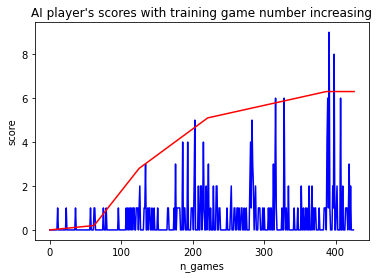

In [19]:
plt.plot(list(range(0,scores.size)),scores,color='b',label='per_game')
plt.plot(averages1[0],averages1[1],c='r',label='max_average')
plt.xlabel('n_games')
plt.ylabel('score')
plt.title('AI player\'s scores with training game number increasing')
plt.show()

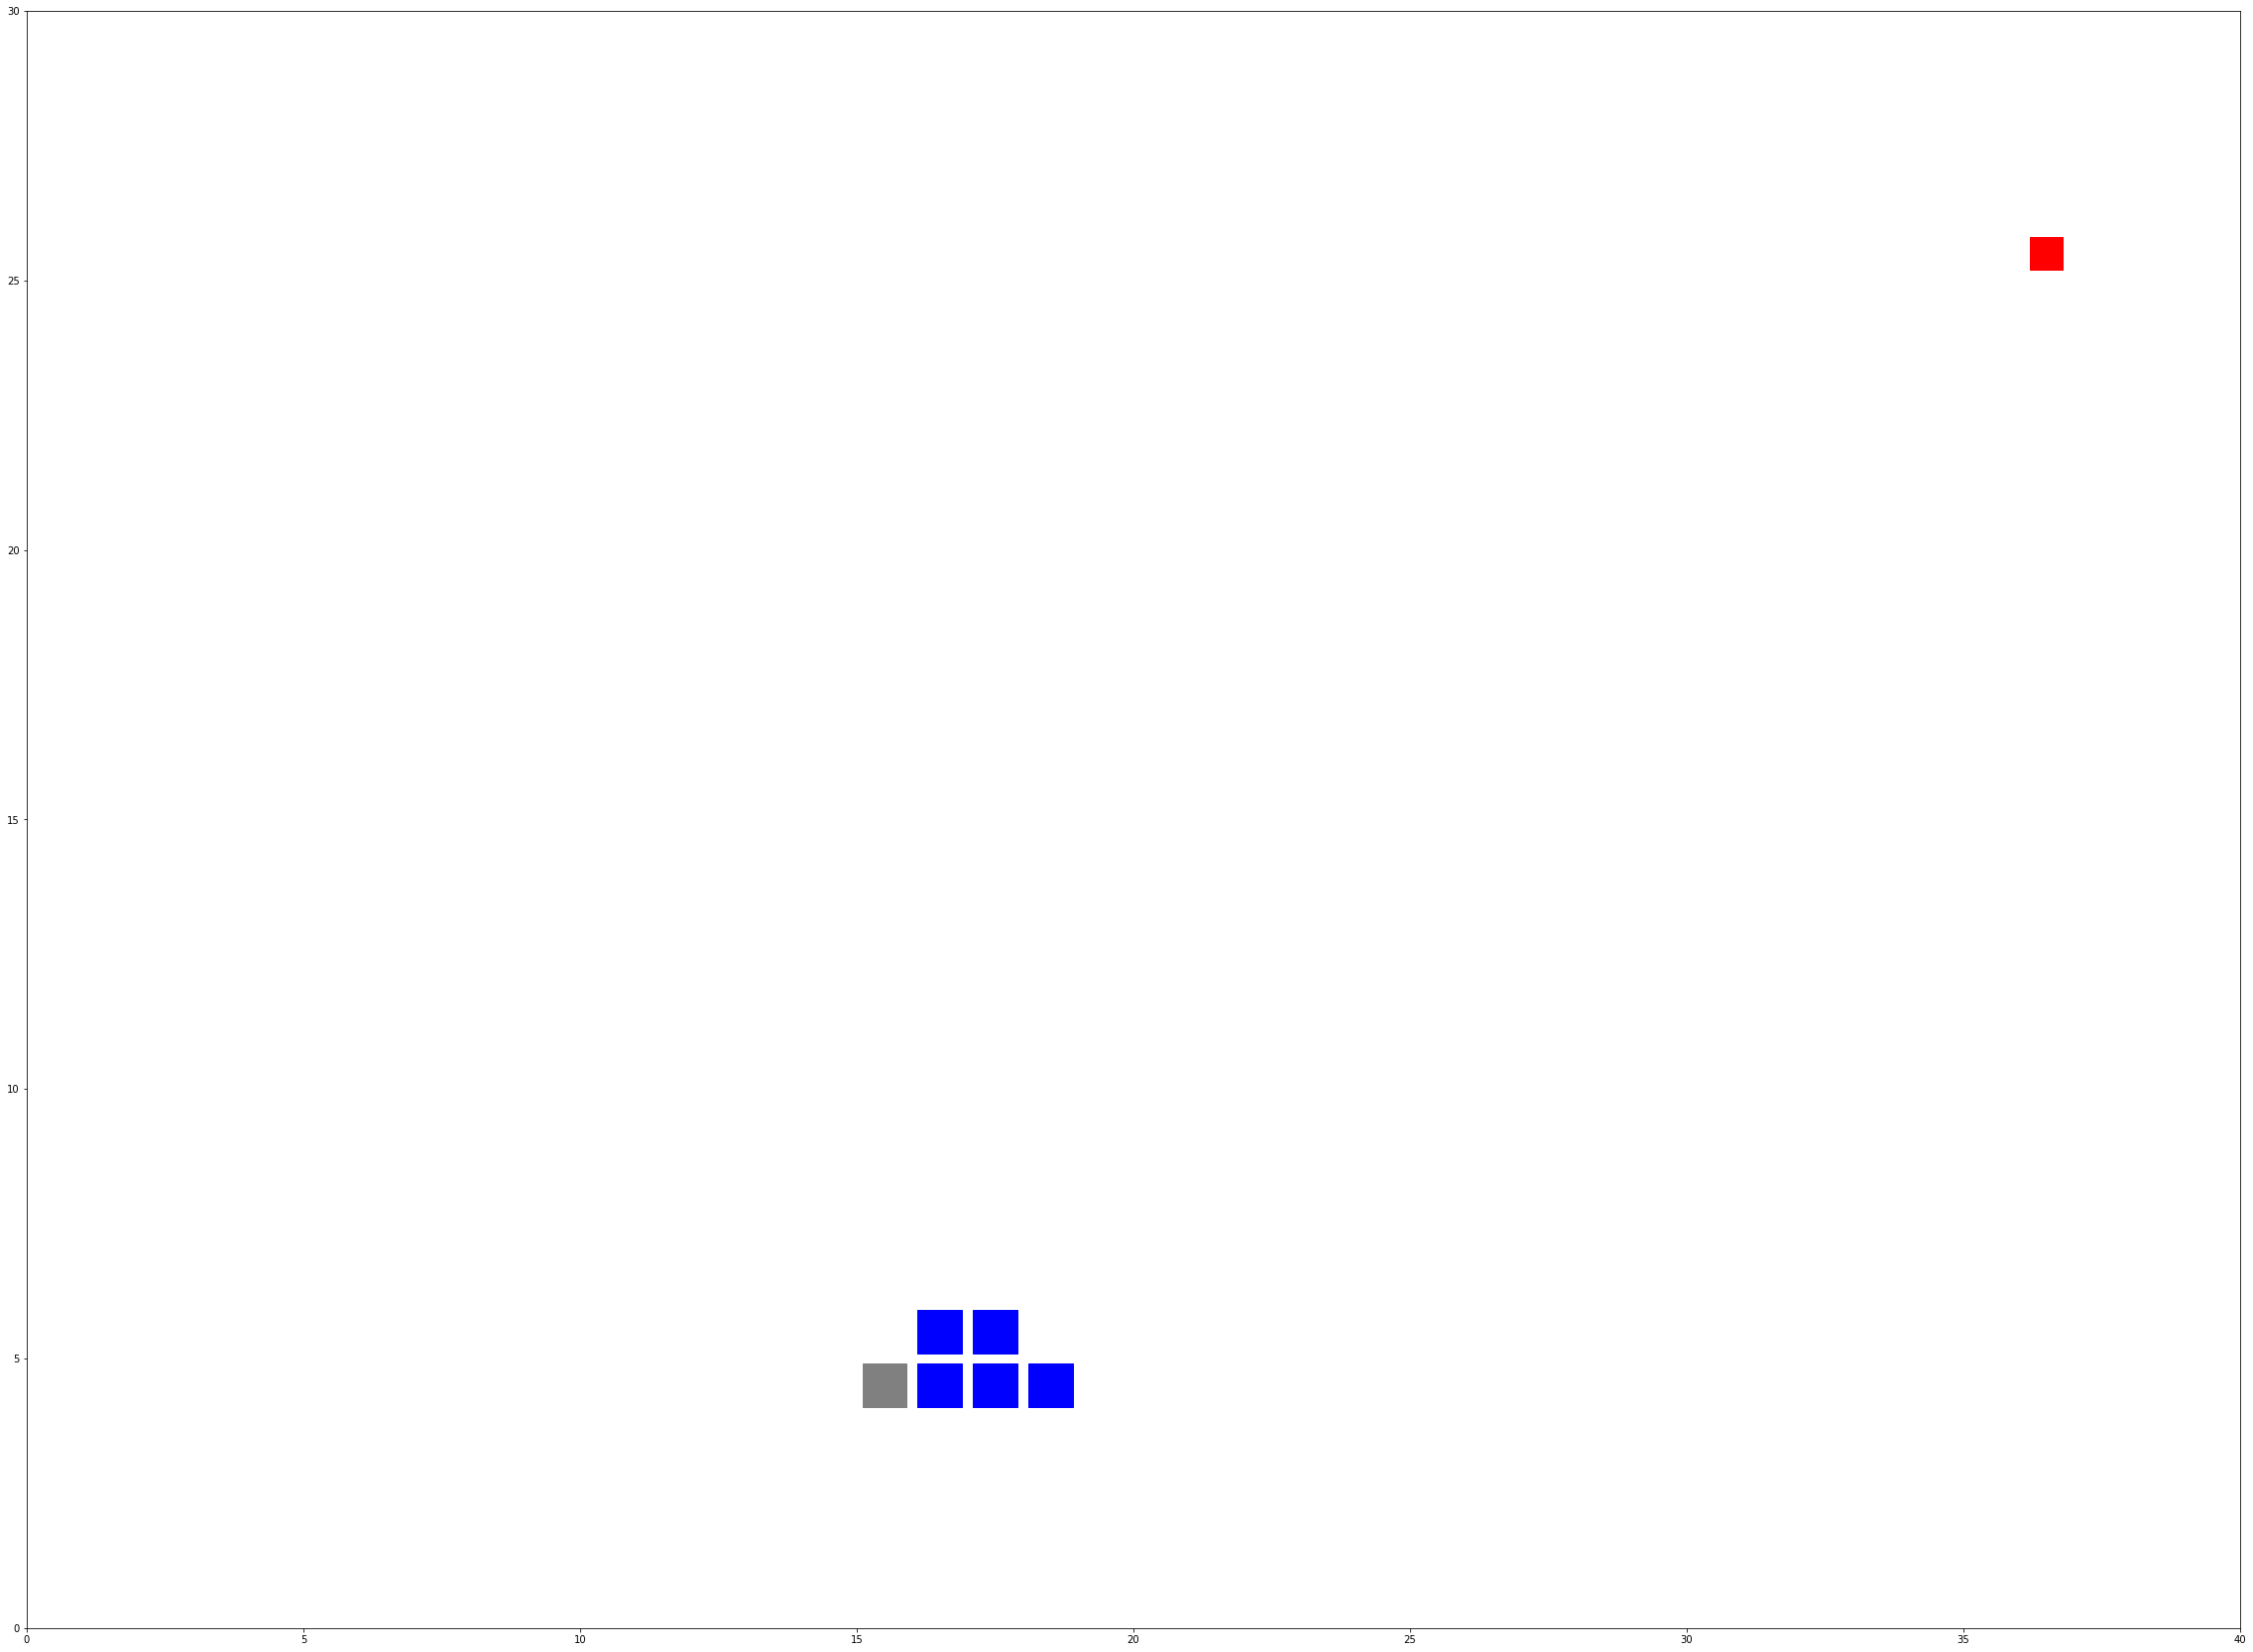

Game over! You got score: 3!


3.0

In [20]:
play(0,player=ai_player(best),gui=True)

In [21]:
[i for i in best.parameters()]

[Parameter containing:
 tensor([[-0.2927, -0.1485,  0.1876,  ...,  0.3005,  0.1814,  0.2810],
         [ 0.0647, -0.0053,  0.2542,  ..., -0.2650, -0.1765,  0.0224],
         [ 0.1192,  0.2733,  0.2934,  ..., -0.1668, -0.1726,  0.0182],
         ...,
         [ 0.0211,  0.2506, -0.1070,  ...,  0.1821, -0.0920,  0.0399],
         [ 0.2318, -0.2398, -0.2546,  ...,  0.0730,  0.0544, -0.1427],
         [ 0.0308, -0.0085,  0.1384,  ..., -0.1068, -0.2277,  0.1713]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2355,  0.2053, -0.2583, -0.1489, -0.1875,  0.0721, -0.0428, -0.0434,
         -0.2648, -0.1149,  0.2058,  0.0392, -0.1383,  0.1872, -0.2107,  0.1909,
          0.2082, -0.0881, -0.0396, -0.1742,  0.2396, -0.0073, -0.2153, -0.0450,
          0.2504, -0.2359,  0.0135, -0.2706, -0.2566,  0.0062, -0.1896,  0.2114,
         -0.1605, -0.0385,  0.1966,  0.0306,  0.2964,  0.1532,  0.3195, -0.2315,
         -0.0649,  0.2766, -0.0104,  0.3290, -0.0098, -0.3245,  0.2698, -0.0368

In [22]:
best(torch.tensor([1.0,0,0,0,1,0,0,1,0,0,0]))

tensor([-0.9676, -0.9579, -0.8248], grad_fn=<AddBackward0>)